# CIS545 Final Group Project

By Atmik Ajoy, Vishnu Nair, and Sam Thudium <br>
December 15th, 2022

# Background and Motivation
Over the last decade, one of the major technological breakthroughs in biology has been single cell sequencing. This technique involves isolating single cells from an organism and sequencing (or reading) the DNA or RNA in it. Using DNA sequencing data to predict RNA levels or RNA expression data to predict protein levels would greatly enhance our understanding of the relationship between these levels of cellular biology. This is a very real problem that life science researchers are facing right now and high confidence models to make predictions across genomic modalities and cell differentiation states could significantly augment the types of questions biologists are able to address. 

In this project, we consider the fundamental building blocks of biology: DNA, RNA, and the proteins these molecules encode. Our goal is to use data at one level of the central dogma of biology (which, as shown in the diagram below, states that DNA is transcribed into RNA which is translated into protein) to predict the expression level (the amount of a molecule present in a cell) of the next level. More specifically, using single-cell RNA expression data from human bone marrow stem cells (HSCs), we will predict the corresponding levels of a given set of cell-surface proteins as these stem cells develop into more mature blood cells. 

This data consists of readings from approximately 300,000 cells across 5 time points. We aim to train a series of models (Linear regression, Random Forest, and Feed Forward Neural Net) on the first 4 time points and then to test the model accuracies on data from a later and unseen 5th time point.

Central Dogma Diagram.svg

# Imports

In [1]:
!pip install --quiet sklearn
!pip install --quiet scanpy
!pip install --quiet anndata

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as pn
from os import listdir
import gc
from os.path import join
from matplotlib import ticker
import anndata as an
import scanpy as sc
%matplotlib inline


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.


In [3]:
# CREATE VARIABLES FOR EACH DATA INPUT FILE ACCORDING TO THE FILE'S NAME
DATA_PATH = '../input/open-problems-multimodal/'
for i, file in enumerate(listdir(DATA_PATH)):
    variable_name = file.split('.')[0].upper()
    full_path = DATA_PATH + file
    for_var = f'{variable_name}="{full_path}"'
    exec(for_var)


# Part 1: Cleaning and Exploratory Data Analysis for Multimodal Single-Cell Data 
## 1.1 - Metadata
### 1.1.1 - Read Data 

To begin our exploration of this data, we will read in the metadata file which contains, for each cell id, several fields: the day on which the cell was sampled, the donor id, the cell type, and the technology platform. 

In [4]:
metadata = pd.read_csv(METADATA)
metadata.head()

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq


### 1.1.2 - Preprocessing Steps

Summary statistics on the numerical columns 'day' and 'donor' aren't particularly meaningful, so we'll opt to capture other summaries such as counts of our columns instead. From .info() below, it appears that there are no null values, but let's double check that just to be sure.

Additionally, since we are using only the CITE-seq data from this competition, which measures **RNA** and **protein** levels in single cells, we will drop rows corresponding to the other single-cell technology platform, Multiome. 

In [5]:
print(metadata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281528 entries, 0 to 281527
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   cell_id     281528 non-null  object
 1   day         281528 non-null  int64 
 2   donor       281528 non-null  int64 
 3   cell_type   281528 non-null  object
 4   technology  281528 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.7+ MB
None


In [6]:
print('The number of duplicated cell_ids is: ', metadata.cell_id.duplicated().sum())
print(f'The number of null values in each column of metadata is:\n{metadata.isnull().sum()}')

The number of duplicated cell_ids is:  0
The number of null values in each column of metadata is:
cell_id       0
day           0
donor         0
cell_type     0
technology    0
dtype: int64


In [5]:
print(f'Shape of original metadata: {metadata.shape}')
metadata = metadata[metadata['technology'] == 'citeseq'].drop('technology', axis=1)
print(f'Shape of metadata after dropping Multiome rows and "technology" column: {metadata.shape}')


Shape of original metadata: (281528, 5)
Shape of metadata after dropping Multiome rows and "technology" column: (119651, 4)


### 1.1.3 - EDA of Metadata

We first aim to obtain an understanding of the distributions of each feature. Further we perform a series of visualizations in order to better understand the biological factors that are important in this dataset. 

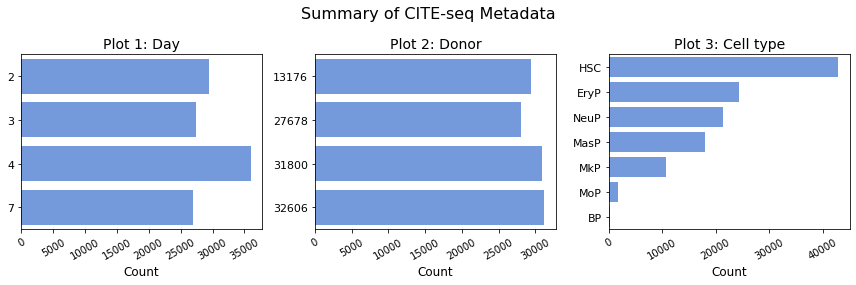

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
idx = 1
for column, ax in zip(metadata.iloc[:,1:].columns, axs.ravel()):
    plot_values = metadata[column].value_counts()
    
    col_name = column.replace('_', ' ').capitalize()
    sns.barplot(y=plot_values.index, x=plot_values, 
                ax=ax, orient='h', color='#6495ED')
    ax.tick_params('x', labelrotation=30)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=11)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_title(f'Plot {idx}: {col_name}')
    ax.set_title(ax.get_title(), fontfamily='Arial', fontsize=14)
    idx += 1
    
plt.suptitle('Summary of CITE-seq Metadata', fontsize=16)
plt.tight_layout()

**Plot 1 ("Day"; left):** More cells were sampled on day 4 and roughly similar numbers were sampled on days 2, 3, and 7. However, we don't think this distribution will should be considered uneven and this helps to ensure that our model is trained on quality data from each day.

**Plot 2: ("Donor"; middle):** Similarly to the distribution of sampling days, cells evenly originate from each of the four donors. 

**Plot 3: ("Cell type"; right):** HSC refers to stem cells. We have nearly 80,000 rows containing stem cell data. We have approximately half the number of cells labeled as other cell types (NeuP, EryP, MasP, MkP). The MoP cell type contains ~3000 rows only. This cell type may be prone to the most prediction error considering the lack of data we have for it.

For further context, we note that the cell abbreviations are defined as follows:
* MasP = Mast Cell Progenitor
* MkP = Megakaryocyte Progenitor
* NeuP = Neutrophil Progenitor
* MoP = Monocyte Progenitor
* EryP = Erythrocyte Progenitor
* HSC = Hematopoietic Stem Cell
* BP = B-Cell Progenitor

These are all blood cells. They originate in our bone marrow as HSCs, which are then capable of differnetiating into the other cell types present here. 

Plotting the number of cells per cell type per day, with the hidden test set cells removed, provides further insight into the distribution of samples we have access to. We can see that there tend to be similar numbers of cells of each type and time point sampled, suggesting that if we were to split our training data into training and validation subsets, we would have representation from each category in both data sets. 

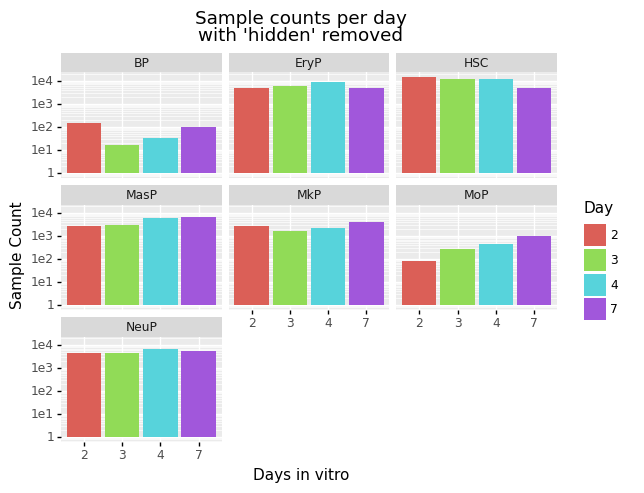

<ggplot: (8744128755801)>

In [31]:
metadata_rm_hidden = metadata[metadata['cell_type'] != 'hidden']

(pn.ggplot(metadata_rm_hidden, pn.aes(x='factor(day)',fill='factor(day)'))
    + pn.geom_bar(position='dodge')
    + pn.facet_wrap('cell_type')
    + pn.labs(title='Sample counts per day\nwith \'hidden\' removed',
              fill='Day\n',
              x='Days in vitro',
              y='Sample Count')
    + pn.scale_y_log10())


As described above, these cells originate from a stem cell population, HSC, and differnetiate (or mature) into the other cell types (among many others not sampled in this dataset). Thus, we would expect the proportion of HSCs to decrease over the timecoure and for the opposite to be true for other cell types. 

In [34]:
def get_grouped_proportion(df, prop_var, grouper, split_col=None, split_val=None):
    if split_col is not None and split_val is not None:
        df = df[df[split_col] == split_val]
    else:
        out = df.groupby(grouper)[prop_var].value_counts().to_frame('count').reset_index()
        out['proportion'] = out['count'] / out.groupby(grouper)['count'].transform('sum')
    
    return out

In [35]:
cell_props = get_grouped_proportion(metadata, 'cell_type', 'day')

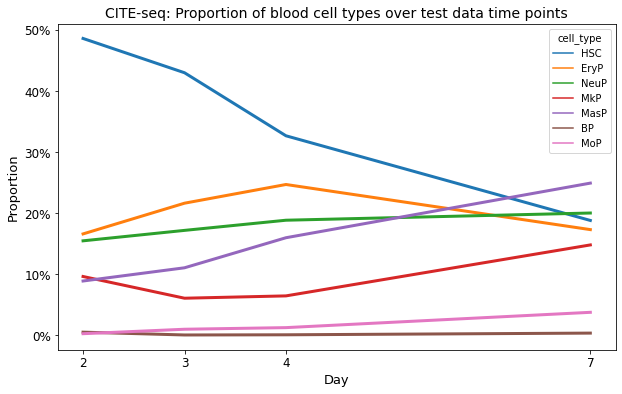

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
hue_order = cell_props['cell_type'].unique()
sns.lineplot(data=cell_props, x='day', y='proportion',\
             ax=ax, hue='cell_type', hue_order=hue_order, linewidth=3)
ax.set_xticks([2,3,4,7], size=11)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_title('CITE-seq: Proportion of blood cell types over test data time points',\
            fontsize=14)
ax.set_xlabel(ax.get_xlabel().capitalize(), fontsize=13)
ax.set_ylabel(ax.get_ylabel().capitalize(), fontsize=13);

# TODO, make legend nicer

As expected, we note how proportions of the cell types change across the timecourse. The ‘HSC’ cell type refers to stem cells. The proportion of stem cells decreases across the 7 day period as they differentiate into specialized cell types (i.e EryP, NeuP, etc.). On the plot above, note the negative slope of the blue line corresponding to proportion of HSCs on each day. We also note that the MasP seems to show most upward variance throughout the 7-day training data period. On the other hand, BP and MoP show the least change during this period, but given the small number of samples labeled by these cell types, this is not surprising. Overall, this data supports the intuition that the day on which a cell was sampled - and thus the day on which the RNA expression (our training data) was determined - is an important factor that ought to be included in our modeling process. 

## 1.2 - CITE-seq Training Input Data
### 1.2.1 - Read Data 

The CITEseq portion of this project involves the prediction of protein levels given RNA expression. The training data is split into two files: (1) 'train_cite_inputs' contains count values of RNA, which have been normalized to library-size (this is the total number of fragments of RNA that were evaluated in each cell) and log1p=[log(X + 1)] transformed; (2) 'train_cite_targets' contains protein-level values from 140 different cell surface proteins. Our goal for this section is to use the RNA data from the inputs file to predict the protein levels in the target file. We begin by cleaning and exploring the inputs file.

The CITE-seq training input data contains rows representing cells, labeled by a unique ID, and columns for every gene in the human genome. The columns are labeled by both a gene ID - specifically an ENSEMBL gene ID beginning with 'ENSG' - and a gene name in the format: {GENE ID}_{GENE_NAME}. The first few rows and columns are shown to familiarize you with the data. We then perform some basic preprocessing steps as with the metadata. 

In [5]:
# Read .h5 file
cite_train_inputs = pd.read_hdf(TRAIN_CITE_INPUTS)

In [62]:
cite_train_inputs.iloc[:10,:5]

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB
cell_id,,,,,,,,,,
45006fe3e4c8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
d02759a80ba2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.000000,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.000000,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000
fbcf2443ffb2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000
d80d84ca8e89,0.0,0.000000,0.0,0.0,0.0,0.000000,3.651999,0.000000,0.000000,3.651999
1ac2049b4c98,0.0,0.000000,0.0,0.0,0.0,0.000000,4.048356,0.000000,0.000000,0.000000
33fb0c29e2e4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.392134,0.000000,3.317969
b329261bd0ee,0.0,3.775647,0.0,0.0,0.0,0.000000,3.775647,0.000000,0.000000,4.457267


### 1.2.2 - Preprocessing Steps

In [63]:
print(f'There are {cite_train_inputs.isna().sum().sum()} NA values in the CITE-seq training data.')
print(f'There are {cite_train_inputs.index.duplicated().sum()} duplicated cell ids in the training data.')

There are 0 NA values in the CITE-seq training data.
There are 0 duplicated cell ids in the training data.


### 1.2.3 - EDA of CITE-seq training inputs

The following matrix visualization on a subset of the input data shows us the prevalence of zero-expression data points. The dark blue points represent zeros and the light green represents non-zero RNA expression values. This is to be expected from single-cell data because out of the 20,000+ genes in the human genome, a given cell will only significantly express a small percentage. This needs to be handled before we model. Feeding features that do not have low variance into a model will not improve, and sometimes even limit performance. We can drop columns that contain a certain proportion of zeros (or all zeros), and also drop columns with very low variance.

Below the sparse matrix plot, we broaden our biological insight by looking at the number of genes a cell typically expresses in this dataset. 

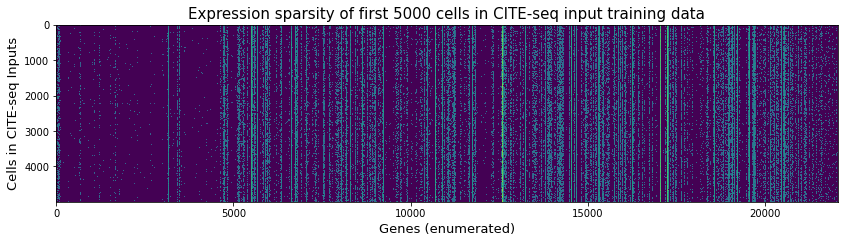

In [60]:
n = 5000
fig = plt.figure(figsize=(14,6));
ax = plt.gca()
ax.matshow(cite_train_inputs[:n]);
plt.xlabel('Genes (enumerated)', fontsize=13);
plt.ylabel('Cells in CITE-seq Inputs', fontsize=13);
plt.title(f'Expression sparsity of first {n} cells in CITE-seq input training data',
         fontsize=15);
ax.xaxis.set_ticks_position('bottom')

We can quantify the sparsity by finding the proportion of the data that has zero expression. Here we take a random sample of the columns in the dataframe and compute the proportion over that. 

In [72]:
def df_prop_zeros(df, n=None, seed=42, axis=None):
    '''Return the porportion of zero-values in a 
       random sample of n columns or rows from dataframe  
    '''
    return df.sample(n=n, random_state=seed, axis=axis)[df == 0].count().sum()\
                    / (df.shape[0] * n)

In [74]:
seed = 42
n = 1000
proportion_zero = df_prop_zeros(cite_train_inputs, n=n, axis=1)
print(f'In this sample of {n} rows, {round(100 * proportion_zero, 3)}% of values are 0')

In this sample, 77.906 % of values are 0


Observing this sparsity in another fashion, we can plot the density of expression values across a sample of of the genes in this dataset. Here again, we see that the RNA expression values are densely clustered at zero. 

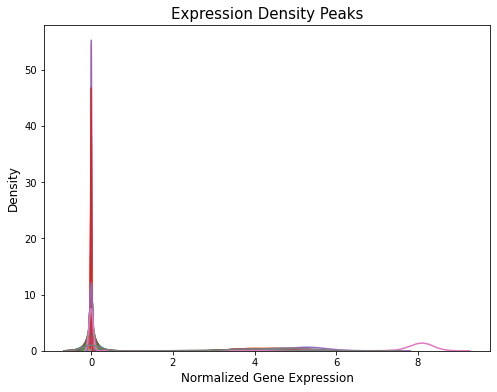

In [79]:
n=50
sample_cols = cite_train_inputs.sample(n=n, axis=1, random_state=123).columns
fig = plt.figure(figsize=(8,6))
for col in sample_cols:
    if cite_train_inputs[col].var() > 0:
        sns.kdeplot(cite_train_inputs[col])
    else:
        continue
    
plt.xlabel('Normalized Gene Expression', fontsize=12);
plt.ylabel('Density', fontsize=12);
plt.title(f'Expression Density Peaks for {n} genes', fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=11)

As expected, below we can seed that the majority of genes express at or near zero in most cells. More interestingly, true gene expression appears to begin around the normalized value of 3, and to peak around 4 or 6. 

As stated earlier, cells in the human body typically express only a subset of the genes encoded by our DNA. This is what allows different cell types to hold the same DNA while performing vastly different functions. This helps to explain the sparsity in the data. The plot below shows that the cells sampled in this data set typically express about 5000 cells. Compared to the 22000 gene-features in the CITE-seq data, this represents just under 25%; recall that the sampled rows from the dataframe were approximately 75% zeros. 

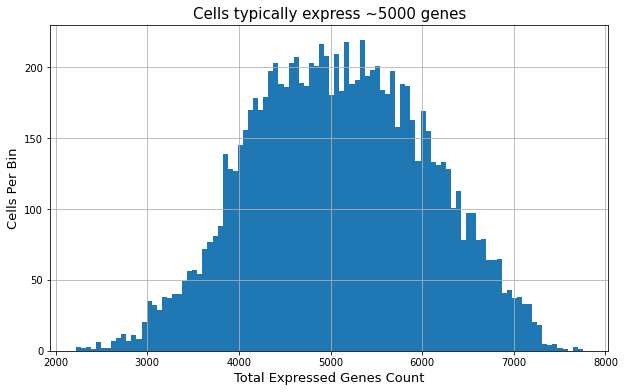

In [24]:
cite_train_inputs.gt(0).sum(axis=1).hist(bins=100, figsize=(10,6));
plt.xlabel('Total Expressed Genes Count', fontsize=13);
plt.ylabel('Cells Per Bin', fontsize=13);
plt.title('Cells typically express ~5000 genes', fontsize=15);

Overall, the plots above show us that this data is quite sparse, suggesting that when we are working on the modeling section of the project we should consider sparse matrices in order to reduce the size of our data. 

The sparsity of the matrix above suggests that we should drop columns - genes - which have 0 expression values for each cell. These genes provide no information when training our models. Additionally, we remove columns with low variance. We'll carry out these steps in the feature selection section of the notebook.

## 1.3 - CITE-seq Training Target Data
### 1.3.1 - Read Data

The training target data is much smaller than the training input data. As in the input data, the instances represent individual cells, labeled by an ID, in which 140 different proteins have been measured. Our goal is to build models to predict these protein level values. Below we read in and print the first five rows of the target data. The dataframe is indexed by cell id and columns are labeled by a protein name. Many of these names begin with "CD", which stands for "cluster of differentiation"; this is just a naming convention in biology for many of the proteins that are tethered to the surfaces of our cells.  

In [6]:
cite_train_targets = pd.read_hdf(TRAIN_CITE_TARGETS)
cite_train_targets.head()
ctt_colnames = cite_train_targets.columns

### 1.3.2 - Preprocessing Steps

In [9]:
print(f'Dimensions of the CITE-seq training targets data: {cite_train_targets.shape}')
print(f'There are {cite_train_targets.isna().sum().sum()} NA values in the CITE-seq target data.')
print(f'There are {cite_train_targets.index.duplicated().sum()} duplicated cell ids in the target data.')

There are 0 NA values in the CITE-seq target data.
There are 0 duplicated cell ids in the target data.


### 1.3.3 - EDA of CITE-seq target data

Below we sample a few columns from the CITE-seq targets dataset. Each column corresponds to a cell-surface protein. These proteins anchor into the cell membrane and protrude from the cell's exterior. The majority are receptors, which bind to specific molecules or other protein fragments and trigger specialized response cascades within the cell. Think of these cascades as a chain of messages that often make their way to the cell's nucleus, where DNA is stored. The message triggers some sort of transciptional resonse (DNA --> RNA), which is then translated (RNA --> protein), and completes the cell's response to the initial information identified by the cell-surface receptor. 

Many fields in biology (immunology comes to mind) might be interested in predicting the amount of a cell surface protein from single-cell RNA expression data. It is already expensive to run single-cell protocols for one modality, so to capture both RNA and protein data at such a granular level is not feasible for most labs. Thus, to be able to capture only one modality - here, RNA - but generate a prediction of another with high confidence would be invaluable.

However, this is a difficult task. As seen below, the surface protein levels are extremely varied. It is also likely that the protein output is not a simple correlation with its RNA level due to the complexity of cellular processes. Overall, we see that this is a complex regression problem that will require a model with sufficient complexity.  

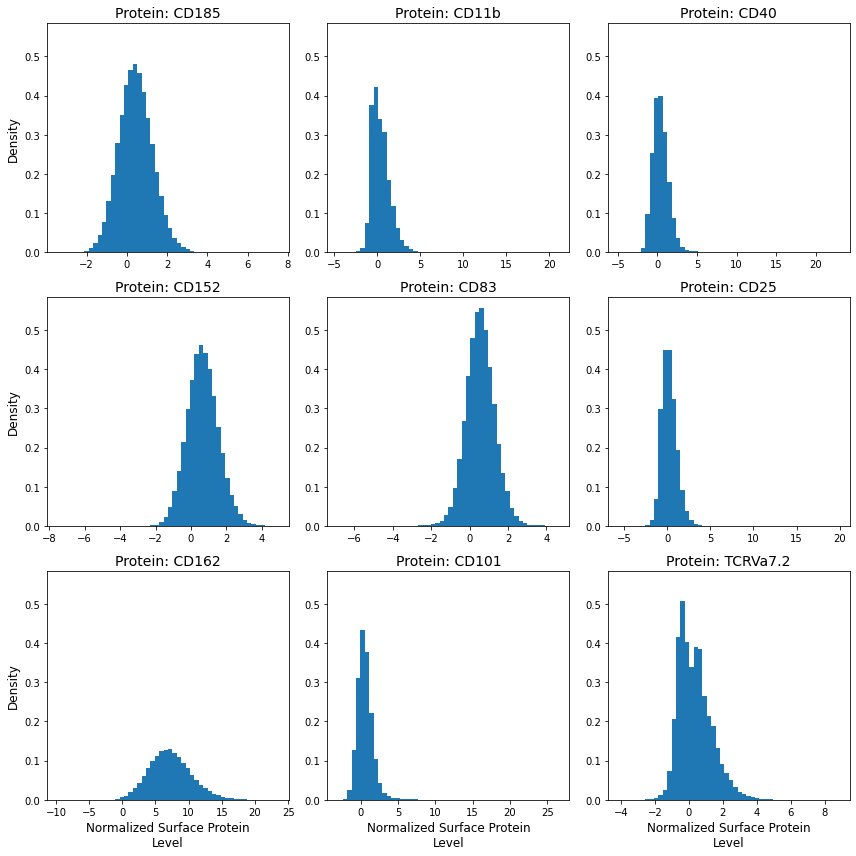

In [56]:
seed=np.random.randint(0,100)
sample_cols = cite_train_targets.sample(n=9, axis=1, random_state=seed).columns
fig, axs = plt.subplots(3, 3, figsize=(12,12), sharey=True)
for col, (i, ax) in zip(sample_cols, enumerate(axs.ravel())): 
    ax.hist(cite_train_targets[col], bins=50, density=True)
    ax.set_title(f'Protein: {col}', fontsize=14)
    ax.yaxis.set_tick_params(labelbottom=True)
    if i in [0, 3, 6]:
         ax.set_ylabel('Density', fontsize=12)
    if i in range(6,9):
        ax.set_xlabel('Normalized Surface Protein\nLevel', fontsize=12)
plt.tight_layout()

Let us now check that the cell ids for the input and target training data match.

In [52]:
ctt_cell_ids = cite_train_targets.index
cti_cell_ids = cite_train_inputs.index

In [55]:
# Check that lengths match
assert len(ctt_cell_ids) == len(cti_cell_ids), 'Input and Target indices are not same length.'
    
# Check that all ids are equivalent 
assert all(ctt_cell_ids.isin(cti_cell_ids)), 'Input and Target cell ids do not match.'

In [ ]:
# Todo, more EDA on the cite_train_targets data

# Part 2: Feature Selection
## 2.1 - Target gene correlation

Our data is structured such that all 22,000+ genes in the human genome are input feature. However, it is probable that RNA expression data from all genes is not required to predict the protein levels of only 140 genes. 

One approach to reduce the number of input features to our models might be to select the genes (columns in our training input data) that encode the target proteins we are attempting to predict. As stated in the central dogma of biology: "DNA makes RNA makes proteins", so we might expect there to be a helpful relationship between the RNA levels seen in our input data and the protein levels we are predicting. However, studies over the last 15 years or so have continually shown that RNA expression alone is a poor predictor of protein levels ([Reimegård et al., 2021](https://www.nature.com/articles/s42003-021-02142-w); [Abreu et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4089977/)). In light of this body of scientific literature, we have decided to skip this more naive approach in favor or other feature selection methonds. 

## 2.2 - Variance thresholding

As shown in section 1.2.3, the data training input data is quite sparse, so one method the number of features being fed into our models would be to set a threshold for the minimum variance of for each gene. By setting a threshold greater than zero, we drop both columns containing all zeros and the columns with variance under our threshold. 

To figure out a good threshold for the variance filter, we use the density of columnwise variances across our data to determine where the majority of the data lies. 

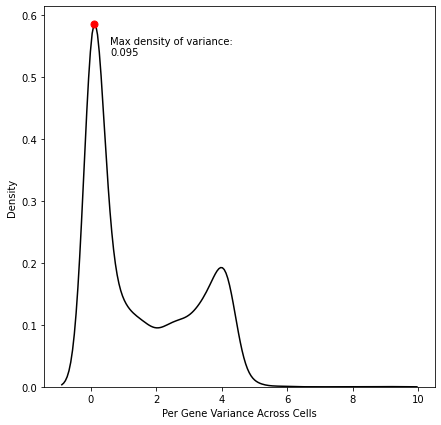

In [8]:
# We may want to consider other ways of determining our variance threshold
gene_vars = cite_train_inputs.sample(frac=0.2, axis=1).agg(np.var).to_frame('gene_variance').reset_index()
fig = plt.figure(figsize=(7,7));
ax = sns.kdeplot(data=gene_vars, x='gene_variance', color='black')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
maxid = np.argmax(y)
plt.plot(x[maxid],y[maxid], marker='o', color='red', ms=7)
plt.text(x=x[maxid]+0.5,y=y[maxid]-0.05,\
         s=f'Max density of variance:\n{str(round(x[maxid], 3))}');
plt.xlabel('Per Gene Variance Across Cells');

# TODO:
    # Add ticks to x and y axes.
    # Add title and make plot background white

Given the above plot, we will set a variance threshold of 0.1 in order to remove low variance genes from our features. 

In [7]:
init_rows, init_cols = cite_train_inputs.shape
print(f'Shape before dropping zero/low variance cols: {init_rows}x{init_cols}')
mask = cite_train_inputs.apply(lambda x: np.var(x) > 0.1)
cite_train_inputs = cite_train_inputs.loc[:,mask]
post_rows, post_cols = cite_train_inputs.shape
print(f'Shape after dropping zero/low variance cols: {post_rows}x{post_cols}')
print(f'Difference: {init_cols - post_cols}')

Shape before dropping zero/low variance cols: 70988x22050
Shape after dropping zero/low variance cols: 70988x16153
Difference: 5897


In [26]:
# Perform some manipulations on the metadata in order to get the cell ids
# corresponding to those in the train_cite_inputs
metadata = metadata.set_index('cell_id').apply(lambda x : x.astype('category')).reset_index()
meta_filtered = metadata[metadata['cell_id'].isin(cite_train_inputs.index)]
meta_filtered.set_index('cell_id', inplace=True)


In [11]:
# del cite_train_inputs
# gc.collect()

201

## 2.3 - UMAP Visualization and One-hot encoding

In order to obtain additional visualizations of this data, we turn to some useful packages built for efficient computation of single-cell expression data. 

In [28]:
# Create and AnnData object, which holds large sequencing matrices and 
# supports a lot of useful data processing methods
# Each column in metadata will now be associated with that cell's RNA expression values
cite_input_ad = an.AnnData(cite_train_inputs, obs=meta_filtered)
# del cite_train_inputs
# gc.collect()

In [29]:
# Drop any cells labeled 'hidden'. 
cite_input_ad = cite_input_ad[cite_input_ad.obs['cell_type'] != 'hidden', :]

In [30]:
# Scale data to zero mean
sc.pp.scale(cite_input_ad)

# Run PCA
sc.tl.pca(cite_input_ad)

# Compute neighbors
sc.pp.neighbors(cite_input_ad, n_neighbors=10, n_pcs=40)

# Compute umap
sc.tl.umap(cite_input_ad)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


In [33]:
# Calculate total counts per cell as well as other summary statistics
sc.pp.calculate_qc_metrics(cite_input_ad, percent_top=None, log1p=False, inplace=True)

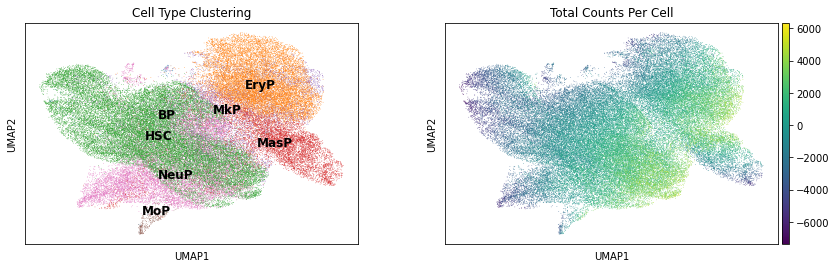

In [44]:
# plot UMAP
sc.pl.umap(cite_input_ad, color=['cell_type', 'total_counts'],
          legend_fontsize='large', legend_loc = 'on data', 
          color_map='viridis', title=['Cell Type Clustering', 'Total Counts Per Cell'])

# TODO:
    # Make the title, axis titles, and color bar numbers larger

Using dimensionality reduction, we can see that the cells in the CITE-seq training inputs separate well based on their assigned cell type. Additionally, by looking at the total counts of these cells in the same reduced dimensions, we can see that certain cell populations tend to have lower counts than others. Together, this data supports the notion that the numerical expression values we will feed into our model represent distinctive populations that contain important variability for training the model. Further, we should include cell type as one hot encoded features in the training data. 

In [48]:
del meta_filtered, cite_input_ad
gc.collect()

2565

## 2.4 - Selection of top variance features

In [8]:
variances = cite_train_inputs.var()

var_list = []
for i in variances:
    var_list.append(i)
var_pop = list(zip(cite_train_inputs,var_list))
var_pop.sort(key = lambda x: x[1], reverse=True)

trainlist1 = var_pop[:1000]

def getDF(trainlist, traindf):
    keep_columns = []
    for item in trainlist:
        gene_id = item[0]
        keep_columns.append(gene_id)
    output_df = traindf[keep_columns]
    output_df = output_df.reset_index()
    return output_df


traindf1 = getDF(trainlist1,cite_train_inputs).set_index('cell_id')


## 2.5 - One-Hot Encoding Metadata Features

In [9]:
metadata = metadata.set_index('cell_id')

In [10]:
## TODO: one hot encode metadata features and add to RNA expression input
meta_dummies = pd.get_dummies(metadata[['day', 'cell_type']])

In [11]:
traindf1 = traindf1.join(meta_dummies, on='cell_id')
# traindf2 = traindf2.join(meta_dummies, on='cell_id')
# traindf3 = traindf3.join(meta_dummies, on='cell_id')
# traindf4 = traindf4.join(meta_dummies, on='cell_id')

In [14]:
for i, df in enumerate([traindf1]):
    print(f'Shape of traindf{i+1}: {df.shape}')

Shape of traindf1: (70988, 1009)


In [15]:
del cite_train_inputs
gc.collect()

294

In [17]:
def pearson(X, y):
    n=X.shape[1]
    assert n==y.shape[1]
    xmean=np.mean(X,axis=1)
    ymean=np.mean(y,axis=1)
    A=np.sum(X**2, axis=1) - n*xmean**2
    B=np.sum(y**2, axis=1) - n*ymean**2
    C=np.sum(X*y, axis=1)
    corr=(C-n*xmean*ymean)/ np.sqrt(A*B)
    return corr

# Part 3: Modelling
## 3.1 - Top 1000 genes with greatest variance


In [16]:
# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from collections import defaultdict

In [19]:
# Generate multioutput regression train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    traindf1.values, cite_train_targets.values, 
    test_size=0.3, random_state=42)

### 3.1.1 - Linear Regression

Using the top 1000 genes with highest variance across cells, we will attempt to build a model that can predict the protein levels of the cell-surface target proteins. First, we split the data into train and test sets. Here, since we have so much training data we opt to use 70% of the data as the training set and leave 30% for testing. We begin by running a simple linear regression model to get a baseline model to compare others to. We will score the models based on the mean squared error across each of the 140 targets. 

In [20]:
reg = MultiOutputRegressor(LinearRegression())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
linear_pearson = pearson(y_pred, y_test)

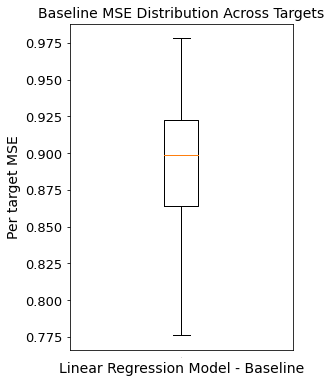

In [22]:
fig = plt.figure(figsize=(4,6))
plt.boxplot(linear_pearson, showfliers=False)
plt.title('Baseline MSE Distribution Across Targets', fontsize=14)
plt.ylabel('Per target MSE', fontsize=14);
plt.xlabel('Linear Regression Model - Baseline', fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=1, bottom=False)
plt.tick_params(axis='y', which='major', labelsize=13, bottom=False)


In [42]:
print(f'The median pearson correlation across 140 target proteins using a basic Linear Regression model is: {round(np.median(linear_pearson),4)}')

The median pearson correlation across 140 target proteins using a basic Linear Regression model is: 0.8985


### 3.1.2 - Lasso Regression

Above we tested a simple linear regression model to predict protein levels acorss 140 targets. Since we have so many features in this dataset and it is difficult to know what that realtive importance of a given gene will be on the amount of the target proteins, Lasso (L1 regularization) may be a beneficial modeling technique to use. The reality of biology is that to determine the optimal feature set for the set of target proteins we are to predict is nearly impossible; certainly, if the goal is to build models useable in research and industry, it is not feasible to use literature to uncover every cited interaction between features at the RNA level and protein outputs. In most cases, this research will not exist and is likely an incomplete picture. Thus, it would be better for our model to learn these relationships in training. By using an L1 penalty, we will drive unimportant features toward zero, effectively performing additional feature selection during the modeling process. 

In [30]:
alphas = [0.1,1,10, 100]
alpha_pearson = defaultdict()

for a in alphas:
    print('Current Iteration on alpha=', a)
    lasso = MultiOutputRegressor(Lasso(alpha=a), n_jobs=-1)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    alpha_pearson[a] = pearson(y_pred, y_test)

Current Iteration on alpha= 0.1
Current Iteration on alpha= 1
Current Iteration on alpha= 10
Current Iteration on alpha= 100


In [37]:
lasso_pearson = pd.DataFrame.from_dict(alpha_pearson).melt(var_name='Alpha', value_name='pearson')

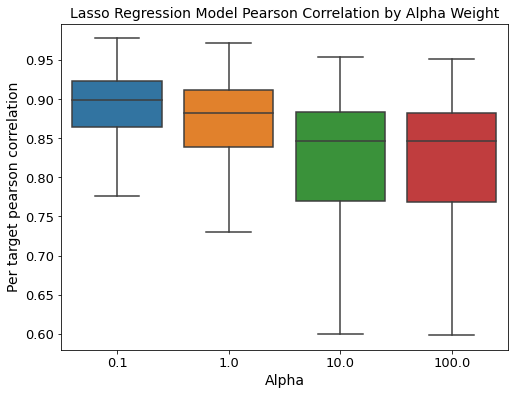

In [38]:
fig=plt.figure(figsize=(8,6))
sns.boxplot(data=lasso_pearson, x='Alpha', y='pearson', showfliers=False)
plt.title('Lasso Regression Model Pearson Correlation by Alpha Weight', fontsize=14)
plt.ylabel('Per target pearson correlation', fontsize=14);
plt.xlabel('Alpha', fontsize=14)
#plt.tick_params(axis='x', which='major', labelsize=1, bottom=False)
plt.tick_params(axis='both', which='major', labelsize=13)


In [45]:
print('The median pearson correlation for each Lasso Model with given alpha is:')
tmp = lasso_pearson.groupby('Alpha')['pearson'].median().reset_index()
tmp

The median pearson correlation for each Lasso Model with given alpha is:


,Alpha,pearson
0,0.1,0.898206
1,1.0,0.882415
2,10.0,0.846603
3,100.0,0.846213


Using the best alpha, we fit on training data and predict the values of the target proteins in the test set. Thus, this prediction contains, for every cell in the test set, a prediction for each of the 140 target proteins that were measured. We can then compare these predictions to the true protein levels given in the test set.

In [46]:
print(f'The median pearson correlation across 140 target proteins using a Lasso Regression model\nwith alpha=0.1 is: {round(tmp.iloc[0,1],4)}.')

The median pearson correlation across 140 target proteins using a Lasso Regression model
with alpha=0.1 is: 0.8982.


Interestingly, the average pearson across all 140 targets is not improved by Lasso Regression. 

### 3.1.3 - Adding more Regularization with ElasticNet

Above, we tried the Lasso (L1) regularization technique. This is a method which takes a set of correlated variables, picks one, and ignores the other variables entirely. In order to overcome this shortcoming and ensure that we are not disregarding potentially important variables that may yield more accurate predictions, we try one more regularization technique: elastic net. Through combination of feature elimination from Lasso and feature coefficient reduction from Ridge, we hope to attain better results than Lasso alone. 


In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
alpha=[0.25, 0.5, 0.75, 1]
lassos=[0.5, 0.6, 0.75]
EN_pearson_scores = OrderedDict()
EN_losses = OrderedDict()
for a in alpha:
    for l1 in lassos:
        print(f'Current params: a-{a}_l1-{l1}')
        model = MultiOutputRegressor(ElasticNet(alpha=a, l1_ratio=l1, 
                                                selection='random'))
        model.fit(X_train2, y_train2)
        y_pred = model.predict(X_validate)
        score = pearson(y_pred, y_validate)
        EN_pearson_scores[f'a-{a}_l1-{l1}'] = score
        EN_losses[f'a-{a}_l1-{l1}'] = model.score(X_validate, y_validate)
tmp = pd.DataFrame(EN_pearson_scores)
tmp.to_csv('ElasticNet_pearsonScores.csv')       
        

In [31]:
EN_pearson = tmp.melt(var_name='EN_params', value_name='pearson_score')
EN_pearson

,EN_params,pearson_score
0,a-0.25_l1-0.5,0.899552
1,a-0.25_l1-0.5,0.817373
2,a-0.25_l1-0.5,0.932188
3,a-0.25_l1-0.5,0.853739
4,a-0.25_l1-0.5,0.937209
...,...,...
136291,a-1_l1-0.75,0.892288
136292,a-1_l1-0.75,0.779342
136293,a-1_l1-0.75,0.893387
136294,a-1_l1-0.75,0.781101


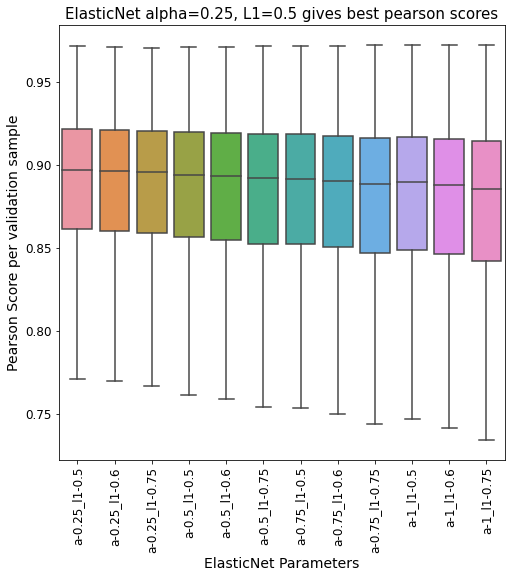

In [38]:
fig = plt.figure(figsize=(8,8))
p = sns.boxplot(data=EN_pearson, x='EN_params', y='pearson_score', showfliers=0)
plt.xlabel('ElasticNet Parameters', fontsize=14)
plt.ylabel('Pearson Score per validation sample', fontsize=14)
plt.title('ElasticNet alpha=0.25, L1=0.5 gives best pearson scores', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90);


From our results using linear models both regularized and unregularized, we can conclude that regularization on this set of features does not significantly improve our results. Both Lasso and Elastic Net resulted in median Pearson correlation values of about 0.90, which is approximately the same as our baseline linear regression model result. This may be due to the fact that our 1000 features being used are the ones containing the most variance in the dataset. If we introduce penalties to zero out or reduce the coefficients of these features, we may lose predictive power. We ascertain that these features must all be kept and not modified/reduced in coefficient value in order to maintain predictive power in our models.

### 3.1.3 - RandomForestRegression

Since regularized forms of linear models are not showing improvements in our prediction correlations, we next choose to try an ensemble learning approach to see if we attain more accurate predictions. Random forest regression takes a specified number of estimators (decision trees) and averages the results to attain the final prediction. It uses an MSE cost function and splits the dataset iteratively until reaching a specified max depth (in this case we specified 10). We choose this ensemble approach as opposed to a simple decision tree because the latter is very prone to overfitting. By feeding in gene expression levels and splitting iteratively to come up with these predictions, we hope to attain better results. 

In [84]:
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

In [ ]:
max_depth=[0.5, 0.6, 0.75]
rfr_pearson = defaultdict()

for depth in max_depth:
    model = MultiOutputRegressor(RandomForestRegressor(max_depth=depth))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rfr_pearson[depth] = pearson(y_pred, y_validate)

tmp = pd.DataFrame(rfr_pearson)

In [44]:
tmp = tmp.melt(var_name='max_depth', value_name='pearson_score')
means = tmp.groupby('max_depth')['pearson_score'].mean().reset_index()
v_offset = tmp['pearson_score'].mean() * 0.01

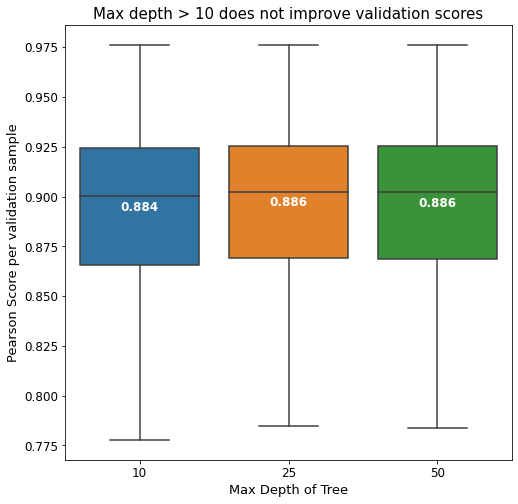

In [70]:
fig = plt.figure(figsize=(8,8))
p = sns.boxplot(data=tmp, y='pearson_score', x='max_depth', showfliers=0)
plt.xlabel('Max Depth of Tree', fontsize=13)
plt.ylabel('Pearson Score per validation sample', fontsize=13)
plt.title('Max depth > 10 does not improve validation scores', fontsize=15)

for xtick in p.get_xticks():
    p.text(xtick,means.iloc[xtick,1] + v_offset,round(means.iloc[xtick,1],3), 
            horizontalalignment='center',size='large',color='w',weight='semibold')
    
plt.tick_params(axis='both', which='major', labelsize=12)

In [22]:
per_cell_corr = pearson(rfr.predict(X_test), y_test)

In [26]:
print(f'Pearson1 corr mean is: {np.mean(per_cell_corr)}')
print(f'Pearson2 corr mean is: {np.mean(other_metric)}')

Pearson1 corr mean is: 0.8849683210751067
Pearson2 corr mean is: 0.8849683211199582


### 3.1.4 - HistGradientBoostingRegressor test

We next attempted to generate a more powerful model via another approach - boosting. In particular, we chose to implement the HistGradientBoostingRegressor from sklearn, which is inspired by the popular LightGBM model. This HistGBM model is optimized for big data (in the documentation they suggest it for data with > 10,000 samples, which we have). The interesting difference for this model in comparison to traditional gradient boosting models is that it partitions the data into (by default) 256 bins, which dramatically reduces the number of node splits that need to be considered. The result is a fast and powerful regressor. 

In [50]:
hist_pearson=pd.read_csv('../input/histgradboost-pearsons/HistGradientBoost_pearsonScores.csv')

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
l2s=[0,0.25,0.5]
boost_scores = OrderedDict()
for l2 in l2s:
    MultiOutputRegressor
    hgbr = MultiOutputRegressor(HistGradientBoostingRegressor(max_depth=10, max_iter=25, verbose=5,
                                                            l2_regularization=l2, warm_start=True))
    hgbr.fit(X_train2, y_train2)
    y_pred = hgbr.predict(X_validate)
    score = pearson(y_pred, y_validate)
    boost_scores[l2] = score
    
tmp = pd.DataFrame(boost_scores)
tmp.to_csv('HistGradientBoost_pearsonScores.csv')

In [52]:
hist_pearson = hist_pearson.iloc[:,1:].melt(var_name='L2_param', value_name='pearson')

In [56]:
hist_medians = hist_pearson.groupby('L2_param')['pearson'].median().reset_index()
v_offset = hist_pearson['pearson'].median() * 0.01

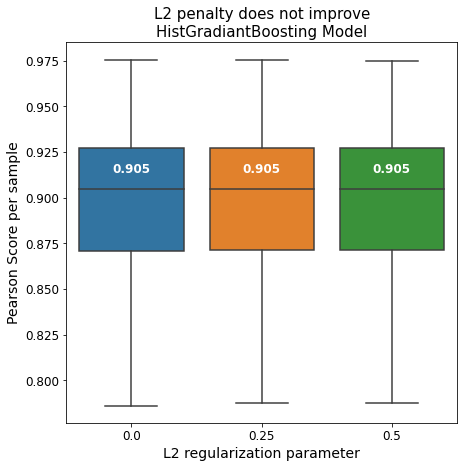

In [61]:
fig = plt.figure(figsize=(7,7))
p=sns.boxplot(data=hist_pearson, x='L2_param', y='pearson', showfliers=False);
plt.xlabel('L2 regularization parameter', fontsize=14)
plt.ylabel('Pearson Score per sample', fontsize=14)
plt.title('L2 penalty does not improve\nHistGradiantBoosting Model', fontsize=15)
for xtick in p.get_xticks():
    p.text(xtick,hist_medians.iloc[xtick,1] + v_offset,round(hist_medians.iloc[xtick,1],3), 
            horizontalalignment='center',size='large',color='w',weight='semibold')
    
plt.tick_params(axis='both', which='major', labelsize=12);


# Part 4 - Conclusions

This project was an ambitious attempt to link modalities of genomic sequencing data via regressor models. To reiterate, one of the most fundamental - but intricate - concepts in biology is that of the central dogma, which states that DNA is transcribed into RNA which is translated into proteins. Proteins are entities that perform work in our cells and allow them to function in so many differnet ways. This project focused on the RNA-to-protein section of the central dogma with the goal of using single-cell RNA expression from all 22000+ genes in the human genome to predict the corresponding protein levels of a select set of 140 cell-surface proteins (here 'expression' and 'levels' can just be read as the amount of the genomic feature that was detected by instrumentation). Solving this problem is key to making single-cell sequencing more widely usable across the many fields of cellular biology. In doing so, we seek to open up avenues to new questions that can be asked by researchers and new discoveries that deepen our understanding of biological systems. 

## 4.1 - EDA

From our EDA we were able to observe many interesting things about our dataset. The data used for the project was broken up into three files: (1) the metadata for every cell measured; (2) the RNA expression values for those cells in each human gene; and (3) the corresponding protein levels in 140 cell-surface proteins. We first explored the metadata in order to gain an understanding for the distributions of important features such as cell type and day of sampling. Using barplots and lineplots, we were able to show that samples were taken evenly across the four timepoints in the dataset, but that the number of samples assigned to each of the 7 cell types were varied. Additionally, we uncovered some interesting biology by looking at the proportion of each cell type across the sampling days, reconstructing the process of cellular differentiation by showing that the proportion of stem cells decreased with time as they turned into the other cell types being measured. 

We next investigated the second file, RNA expression data, and sought to understand the distribution of gene expression values in each sample. Primarily, we found that the expression data is very sparse, which led us to drop columns that were only filled with zeros. Further, by plotting the density of genewise variance within the data, we found a reasonable threshold at which we could drop features, providing us more clean, concise data for modeling purposes. Again, we also were able to demonstrate an interesting biological phenomenon by demonstrating through a histogram that cells tended to express about 25% of all genes, which lines up nicely with scientific liturature.  

Finally, conducting a quick EDA of protein levels, we saw that they tend to be quite varied from one another, suggesting that there may be complex relationships at play between gene expression levels and each protein target. Overall, we were able to understand the distributions of gene expression data, clean our dataset through the dropping of features, and characterize trends in the data by each cell type. Ultimately, EDA was instructive in feature selection and our decision to one hot encode the cell type variable.

## 4.2 - Modeling

Ultimately, given the computational intensity of our multioutput regression problem, we elected to utilize the top 1000 most varied features in the data, as well as the cell type information. From our analysis and modeling, it seems that simple linear regression yields the best results. We are able to predict protein levels across the 140 targets with a Pearson correlation coefficient of just under 0.90. This means that, on a per cell basis, our predicted protein levels are highly correlated with the actual protein levels using the top 1000 features with highest variance. This suggests that gene expression levels and protein levels are likely to be linearly related in this dataset. We attempted to introduce multiple methods of regularization to generate a model that predicted on only the most influential features, but found that increasing regularization actually tended to reduce the pearson correlation of the predictions and observed protein levels. 

We also tried non-linear models in the forms of RandomForest and a boosted tree regressor called HistGradientBoostingRegressor. Again, we did not see a dramatic increase in the median correlation using these models, thought the boosted tree model, which bins the data into a 256 bin histogram in order to speed up splitting decisions, was marginally more effective than both the linear models and the random forest regressor. 

Overall, with additional time to run hyperparameter tuning, we could have likely acheived greater correlation scores through these non-linear models. Unfortunately, each output had to compute 140 different models, one for each of the target proteins, so the training times for this sections were a limiting factor. 

## 4.3 - Future Directions

Going forward, we believe that isolating a larger number of high-variance features (perhaps top 5,000) will yield even better results to capture more intricate non-linear trends. It is likely that the biological complexity of the relationship between RNA and protein levels is too great to be captured in only the top 1000 most variable genes. Further, performing better hyperparameter tuning through techniques such as GridSearchCV would allow us to find the optimal values for these models. This would be especially helpful with the boosted gradient regressor, which has many parameters that we simply did not have time to change. Additionally, being able to do dimensionality reduction would be hugely beneficial; performing our analysis in a distributed environment might allow us to run PCA on the full dataset. Another problem we ran into was the maximum number of principal components specified by sklearn is 10000, but we hoped to invstigate the explained variance ratio beyond this number. Finally, we could try to use a neural net to predict values for the 140 target proteins. Given the complex nature of the data and the large number of samples, we could explore more complex models to see if they better capture the intricacies of the relationship between features and targets.